# Overlap Variation Analysis: Energy Barrier vs Overlap Length

This notebook investigates the hypothesis that **energy barriers increase with increasing gene overlap**.

## Approach:
1. For each overlap value, generate a small pool of functional sequences
2. Select the pair with lowest Hamming distance (easiest evolutionary path)
3. Use Genetic Algorithm to find optimal mutation ordering
4. Record the maximum energy barrier along the path
5. Plot energy barrier vs overlap to test the hypothesis

## 1. Setup and Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from tqdm.auto import tqdm
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')

# Import local module
import overlappingGenes as og

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Reproducibility
np.random.seed(42)

## 2. Load DCA Parameters

In [15]:
PROTEIN_1 = 'PF00004'
PROTEIN_2 = 'PF00041'

print(f"Loading DCA parameters for {PROTEIN_1}...")
Jvec_1, hvec_1 = og.extract_params(f'{PROTEIN_1}/{PROTEIN_1}_params.dat')
nat_energies_1 = og.load_natural_energies(f'{PROTEIN_1}/{PROTEIN_1}_naturalenergies.txt')
mean_e1, std_e1 = np.mean(nat_energies_1), np.std(nat_energies_1)
print(f"  Length: {len(hvec_1)//21} AA, Mean energy: {mean_e1:.2f} ± {std_e1:.2f}")

print(f"\nLoading DCA parameters for {PROTEIN_2}...")
Jvec_2, hvec_2 = og.extract_params(f'{PROTEIN_2}/{PROTEIN_2}_params.dat')
nat_energies_2 = og.load_natural_energies(f'{PROTEIN_2}/{PROTEIN_2}_naturalenergies.txt')
mean_e2, std_e2 = np.mean(nat_energies_2), np.std(nat_energies_2)
print(f"  Length: {len(hvec_2)//21} AA, Mean energy: {mean_e2:.2f} ± {std_e2:.2f}")

DCA_params_1 = (Jvec_1, hvec_1)
DCA_params_2 = (Jvec_2, hvec_2)

prot1_len = len(hvec_1) // 21
prot2_len = len(hvec_2) // 21
print(f"\nProtein 1 length: {prot1_len} AA")
print(f"Protein 2 length: {prot2_len} AA")

Loading DCA parameters for PF00004...
  Length: 110 AA, Mean energy: 145.88 ± 38.25

Loading DCA parameters for PF00041...
  Length: 74 AA, Mean energy: 120.66 ± 17.64

Protein 1 length: 110 AA
Protein 2 length: 74 AA


## 3. Configuration

In [16]:
# Overlap values to scan (nucleotides)
# Start at 12 (minimum reliable), go up to 60 in steps of 12
OVERLAPS = range(12, 61, 3)

# Sequence generation parameters
N_SEQUENCES = 15       # Sequences per overlap (small to avoid memory issues)
MC_ITERATIONS = 250_000  # MC iterations per sequence
MC_TEMP_1 = 0.818
MC_TEMP_2 = 0.955

# Genetic Algorithm parameters
GA_POPULATION = 100
GA_GENERATIONS = 150

print(f"Overlaps to scan: {OVERLAPS}")
print(f"Sequences per overlap: {N_SEQUENCES}")
print(f"MC iterations: {MC_ITERATIONS:,}")
print(f"GA: {GA_POPULATION} pop x {GA_GENERATIONS} gen")

Overlaps to scan: range(12, 61, 3)
Sequences per overlap: 15
MC iterations: 250,000
GA: 100 pop x 150 gen


## 4. Core Functions

In [17]:
def generate_functional_sequence(overlap, n_iterations=200_000):
    """Generate a single functional overlapping sequence using MC relaxation."""
    # Generate initial sequence (og.initial_seq_no_stops works for overlap >= 6)
    initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
    
    # Run MC relaxation
    result = og.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, initial_seq,
        T1=MC_TEMP_1, T2=MC_TEMP_2,
        numberofiterations=n_iterations,
        quiet=True,
        whentosave=100.0,  # Don't save history (saves memory)
        nat_mean1=mean_e1,
        nat_mean2=mean_e2
    )
    
    best_seq = result[6]      # Best sequence (closest to natural energies)
    best_energies = result[5]  # [E1, E2]
    
    return best_seq, best_energies


@njit
def calculate_total_energy(seq_str, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2):
    """Calculate total energy (E1 + E2) for an overlapping sequence."""
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2
    
    seq = og.seq_str_to_int_array(seq_str)
    len_seq_1_n = len_aa_1 * 3
    len_seq_2_n = len_aa_2 * 3
    
    aa_seq_1 = np.empty(len_aa_1, dtype=np.int32)
    aa_seq_2 = np.empty(len_aa_2, dtype=np.int32)
    rc_buffer = np.empty(len_seq_2_n, dtype=np.uint8)
    
    og.split_sequence_and_to_numeric_out(seq, len_seq_1_n, len_seq_2_n, aa_seq_1, aa_seq_2, rc_buffer)
    
    # Check for internal stop codons
    for i in range(len_aa_1 - 1):
        if aa_seq_1[i] == 21:
            return np.inf
    for i in range(len_aa_2 - 1):
        if aa_seq_2[i] == 21:
            return np.inf
    
    E1 = og.calculate_Energy(aa_seq_1[:-1], Jvec1, hvec1)
    E2 = og.calculate_Energy(aa_seq_2[:-1], Jvec2, hvec2)
    
    return E1 + E2


def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))


def get_mutation_path(seq1, seq2):
    """Get list of positions where sequences differ."""
    return [(i, seq1[i], seq2[i]) for i in range(len(seq1)) if seq1[i] != seq2[i]]


def find_closest_pair(sequences):
    """Find the pair of sequences with minimum Hamming distance."""
    n = len(sequences)
    min_dist = float('inf')
    best_pair = (0, 1)
    
    for i in range(n):
        for j in range(i + 1, n):
            d = hamming_distance(sequences[i], sequences[j])
            if d < min_dist:
                min_dist = d
                best_pair = (i, j)
    
    return best_pair, min_dist

In [18]:
def evaluate_path_fitness(path_order, seq_start, mutations, len_aa_1, len_aa_2):
    """Evaluate max energy along a mutation path."""
    current_seq = seq_start
    max_energy = calculate_total_energy(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
    
    for idx in path_order:
        pos, old_nt, new_nt = mutations[idx]
        current_seq = current_seq[:pos] + new_nt + current_seq[pos+1:]
        energy = calculate_total_energy(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
        if energy > max_energy:
            max_energy = energy
    
    return max_energy


def get_path_energies(path_order, seq_start, mutations, len_aa_1, len_aa_2):
    """Get energies at each step along the path."""
    current_seq = seq_start
    energies = [calculate_total_energy(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)]
    
    for idx in path_order:
        pos, old_nt, new_nt = mutations[idx]
        current_seq = current_seq[:pos] + new_nt + current_seq[pos+1:]
        energies.append(calculate_total_energy(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2))
    
    return np.array(energies)


class GeneticPathFinder:
    """GA to find optimal mutation ordering that minimizes max energy barrier."""
    
    def __init__(self, seq_start, seq_end, len_aa_1, len_aa_2,
                 pop_size=50, n_generations=100, mutation_rate=0.15, elitism=0.1):
        self.seq_start = seq_start
        self.seq_end = seq_end
        self.len_aa_1 = len_aa_1
        self.len_aa_2 = len_aa_2
        
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.elitism_count = max(1, int(elitism * pop_size))
        
        self.mutations = get_mutation_path(seq_start, seq_end)
        self.n_mutations = len(self.mutations)
        self.fitness_history = []
    
    def run(self, verbose=False):
        if self.n_mutations == 0:
            return [], 0, np.array([])
        
        # Initialize population
        population = [np.random.permutation(self.n_mutations).tolist() for _ in range(self.pop_size)]
        
        best_individual = None
        best_fitness = float('inf')
        
        iterator = tqdm(range(self.n_generations), desc="GA", leave=False) if verbose else range(self.n_generations)
        
        for gen in iterator:
            # Evaluate
            fitnesses = np.array([evaluate_path_fitness(ind, self.seq_start, self.mutations, 
                                                        self.len_aa_1, self.len_aa_2) 
                                  for ind in population])
            
            # Track best
            gen_best_idx = np.argmin(fitnesses)
            if fitnesses[gen_best_idx] < best_fitness:
                best_fitness = fitnesses[gen_best_idx]
                best_individual = population[gen_best_idx].copy()
            
            self.fitness_history.append(best_fitness)
            
            # Selection + Elitism
            sorted_idx = np.argsort(fitnesses)
            new_population = [population[i].copy() for i in sorted_idx[:self.elitism_count]]
            
            # Create offspring
            while len(new_population) < self.pop_size:
                # Tournament selection
                p1_idx = sorted_idx[np.random.choice(self.pop_size // 2)]
                p2_idx = sorted_idx[np.random.choice(self.pop_size // 2)]
                parent1, parent2 = population[p1_idx], population[p2_idx]
                
                # Order crossover
                size = len(parent1)
                if size >= 2:
                    start, end = sorted(np.random.choice(size, 2, replace=False))
                    child = [-1] * size
                    child[start:end] = parent1[start:end]
                    remaining = [x for x in parent2 if x not in child[start:end]]
                    idx = 0
                    for i in range(size):
                        if child[i] == -1:
                            child[i] = remaining[idx]
                            idx += 1
                else:
                    child = parent1.copy()
                
                # Mutation (swap)
                if np.random.rand() < self.mutation_rate and len(child) >= 2:
                    i, j = np.random.choice(len(child), 2, replace=False)
                    child[i], child[j] = child[j], child[i]
                
                new_population.append(child)
            
            population = new_population
        
        # Get final path energies
        path_energies = get_path_energies(best_individual, self.seq_start, self.mutations,
                                          self.len_aa_1, self.len_aa_2)
        
        return best_individual, best_fitness, path_energies

## 5. JIT Warmup

In [19]:
print("Warming up JIT compilation...")

# Warmup with a quick sequence generation
warmup_overlap = 12
warmup_seq, _ = generate_functional_sequence(warmup_overlap, n_iterations=1000)

# Warmup energy calculation
len_aa_1 = prot1_len + 1
len_aa_2 = prot2_len + 1
_ = calculate_total_energy(warmup_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)

print("JIT compilation complete!")
del warmup_seq
gc.collect()

Warming up JIT compilation...
JIT compilation complete!


12121

## 6. Main Analysis Loop

In [ ]:
results = []

print(f"Analyzing {len(OVERLAPS)} overlap values...")
print("="*60)

for overlap in OVERLAPS:
    print(f"\n>>> Overlap = {overlap} nucleotides")
    
    # Calculate amino acid lengths for this overlap
    len_aa_1 = prot1_len + 1  # +1 for stop codon
    len_aa_2 = prot2_len + 1
    
    # Step 1: Generate sequences
    print(f"    Generating {N_SEQUENCES} sequences...")
    sequences = []
    energies = []
    
    for i in tqdm(range(N_SEQUENCES), desc=f"    Seq gen", leave=False):
        try:
            seq, e = generate_functional_sequence(overlap, MC_ITERATIONS)
            sequences.append(seq)
            energies.append(e)
        except Exception as ex:
            print(f"    Warning: Sequence {i} failed: {ex}")
    
    if len(sequences) < 2:
        print(f"    ERROR: Not enough sequences generated. Skipping overlap {overlap}.")
        gc.collect()
        continue
    
    energies = np.array(energies)
    print(f"    Generated {len(sequences)} sequences")
    print(f"    Energy range: E1=[{energies[:,0].min():.1f}, {energies[:,0].max():.1f}], E2=[{energies[:,1].min():.1f}, {energies[:,1].max():.1f}]")
    
    # Step 2: Find closest pair
    (p1, p2), ham_dist = find_closest_pair(sequences)
    print(f"    Closest pair: ({p1}, {p2}) with Hamming distance = {ham_dist}")
    
    seq_start = sequences[p1]
    seq_end = sequences[p2]
    
    # Step 3: Run Genetic Algorithm
    print(f"    Running GA ({GA_POPULATION} pop x {GA_GENERATIONS} gen)...")
    ga = GeneticPathFinder(seq_start, seq_end, len_aa_1, len_aa_2,
                           pop_size=GA_POPULATION, n_generations=GA_GENERATIONS)
    
    best_order, max_barrier, path_energies = ga.run(verbose=True)
    
    # Store results
    result = {
        'overlap': overlap,
        'hamming_distance': ham_dist,
        'n_mutations': len(ga.mutations),
        'max_energy_barrier': max_barrier,
        'start_energy': path_energies[0] if len(path_energies) > 0 else np.nan,
        'end_energy': path_energies[-1] if len(path_energies) > 0 else np.nan,
        'path_energies': path_energies,
        'fitness_history': ga.fitness_history,
        'mean_e1': energies[:,0].mean(),
        'mean_e2': energies[:,1].mean()
    }
    results.append(result)
    
    print(f"    Results: Max barrier = {max_barrier:.2f}")
    
    # Clean up to prevent memory accumulation
    del sequences, energies, seq_start, seq_end, ga
    gc.collect()

print("\n" + "="*60)
print("Analysis complete!")

Analyzing 17 overlap values...

>>> Overlap = 12 nucleotides
    Generating 15 sequences...


    Generated 15 sequences
    Energy range: E1=[145.7, 146.2], E2=[120.5, 120.9]
    Closest pair: (6, 9) with Hamming distance = 260
    Running GA (100 pop x 150 gen)...


GA:  83%|████████▎ | 124/150 [18:03:30<00:42,  1.65s/it]      

## 7. Results Visualization

In [ ]:
if len(results) == 0:
    print("No results to plot.")
else:
    # Extract data for plotting
    overlaps = [r['overlap'] for r in results]
    barriers = [r['max_energy_barrier'] for r in results]
    ham_dists = [r['hamming_distance'] for r in results]
    start_energies = [r['start_energy'] for r in results]
    
    # Calculate relative barrier (barrier above starting energy)
    relative_barriers = [b - s for b, s in zip(barriers, start_energies)]
    
    print("\nResults Summary:")
    print("-" * 60)
    for r in results:
        rel_bar = r['max_energy_barrier'] - r['start_energy']
        print(f"  Overlap {r['overlap']:2d}: Barrier = {r['max_energy_barrier']:.2f}, "
              f"Relative = {rel_bar:.2f}, Hamming = {r['hamming_distance']}")


Results Summary:
------------------------------------------------------------
  Overlap 12: Barrier = 266.43, Relative = 0.00, Hamming = 267
  Overlap 24: Barrier = 266.56, Relative = 0.00, Hamming = 241
  Overlap 36: Barrier = 266.67, Relative = 0.00, Hamming = 240
  Overlap 48: Barrier = 267.52, Relative = 1.55, Hamming = 241
  Overlap 60: Barrier = 266.51, Relative = 0.00, Hamming = 218


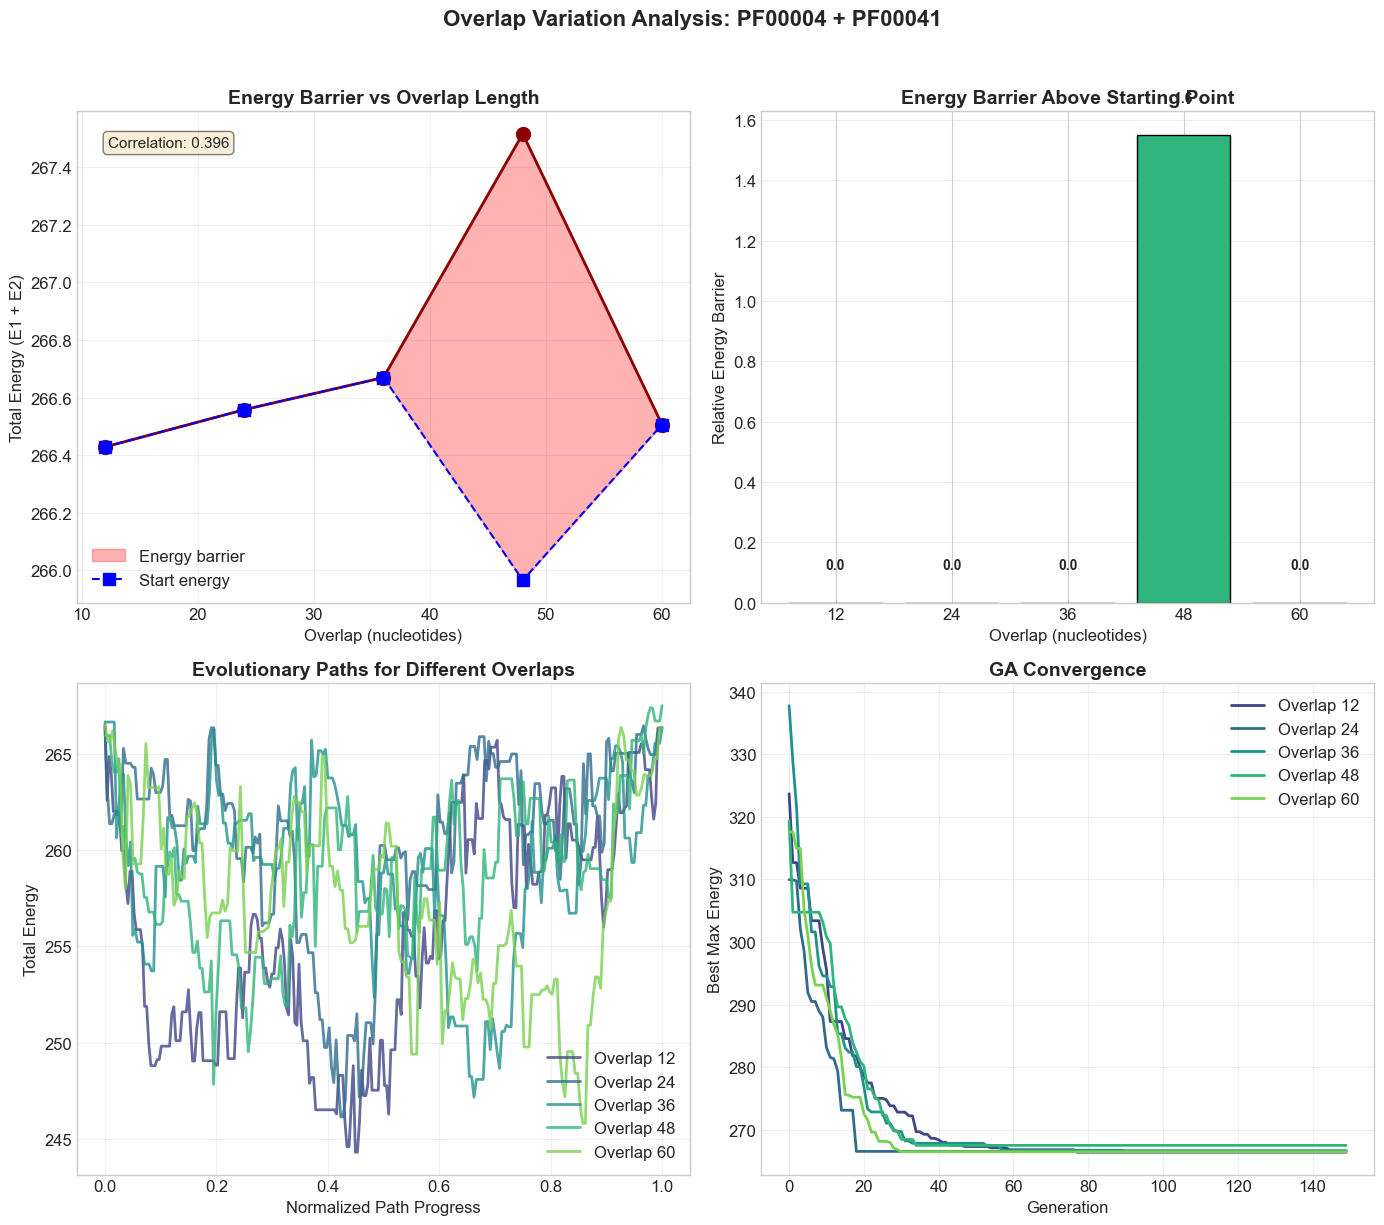

In [ ]:
if len(results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results)))
    
    # Plot 1: Max Energy Barrier vs Overlap
    ax1 = axes[0, 0]
    ax1.plot(overlaps, barriers, 'o-', color='darkred', linewidth=2, markersize=10)
    ax1.fill_between(overlaps, start_energies, barriers, alpha=0.3, color='red', label='Energy barrier')
    ax1.plot(overlaps, start_energies, 's--', color='blue', linewidth=1.5, markersize=8, label='Start energy')
    ax1.set_xlabel('Overlap (nucleotides)', fontsize=12)
    ax1.set_ylabel('Total Energy (E1 + E2)', fontsize=12)
    ax1.set_title('Energy Barrier vs Overlap Length', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add correlation
    if len(overlaps) > 2:
        corr = np.corrcoef(overlaps, barriers)[0, 1]
        ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes, 
                 fontsize=11, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Relative Barrier (above starting point)
    ax2 = axes[0, 1]
    bars = ax2.bar(range(len(overlaps)), relative_barriers, color=colors, edgecolor='black')
    ax2.set_xticks(range(len(overlaps)))
    ax2.set_xticklabels([str(o) for o in overlaps])
    ax2.set_xlabel('Overlap (nucleotides)', fontsize=12)
    ax2.set_ylabel('Relative Energy Barrier', fontsize=12)
    ax2.set_title('Energy Barrier Above Starting Point', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar, val in zip(bars, relative_barriers):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.1f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Evolutionary Paths
    ax3 = axes[1, 0]
    for i, r in enumerate(results):
        path = r['path_energies']
        x = np.linspace(0, 1, len(path))
        ax3.plot(x, path, '-', color=colors[i], linewidth=2, alpha=0.8,
                 label=f"Overlap {r['overlap']}")
    
    ax3.set_xlabel('Normalized Path Progress', fontsize=12)
    ax3.set_ylabel('Total Energy', fontsize=12)
    ax3.set_title('Evolutionary Paths for Different Overlaps', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: GA Convergence
    ax4 = axes[1, 1]
    for i, r in enumerate(results):
        ax4.plot(r['fitness_history'], color=colors[i], linewidth=2, 
                 label=f"Overlap {r['overlap']}")
    
    ax4.set_xlabel('Generation', fontsize=12)
    ax4.set_ylabel('Best Max Energy', fontsize=12)
    ax4.set_title('GA Convergence', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Overlap Variation Analysis: {PROTEIN_1} + {PROTEIN_2}', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('overlap_variation_results.png', dpi=150, bbox_inches='tight')
    plt.show()

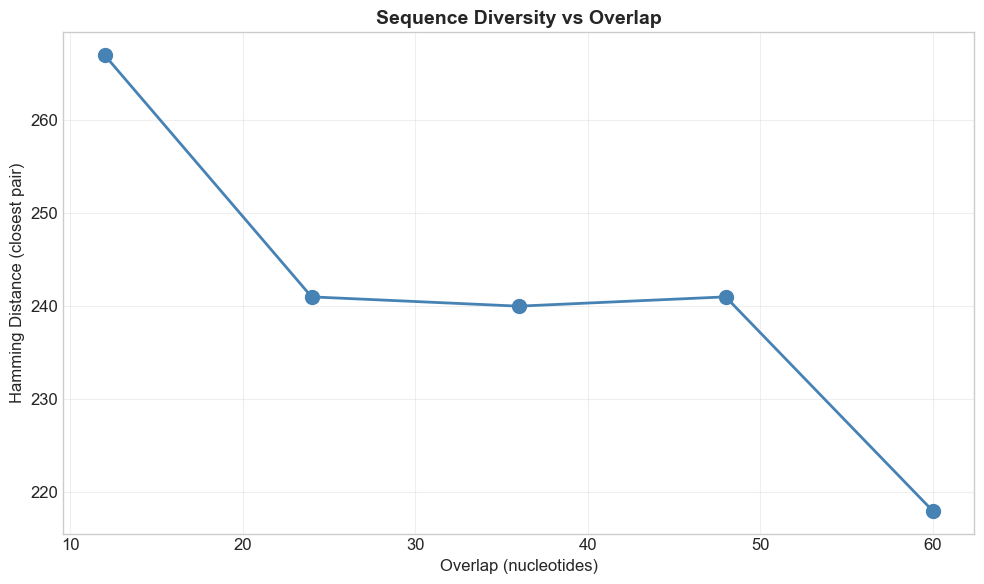

In [ ]:
if len(results) > 0:
    # Additional plot: Hamming distance vs Overlap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(overlaps, ham_dists, 'o-', color='steelblue', linewidth=2, markersize=10)
    ax.set_xlabel('Overlap (nucleotides)', fontsize=12)
    ax.set_ylabel('Hamming Distance (closest pair)', fontsize=12)
    ax.set_title('Sequence Diversity vs Overlap', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('hamming_vs_overlap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Save Results

In [ ]:
if len(results) > 0:
    # Create summary DataFrame
    df = pd.DataFrame([{
        'overlap': r['overlap'],
        'hamming_distance': r['hamming_distance'],
        'n_mutations': r['n_mutations'],
        'max_energy_barrier': r['max_energy_barrier'],
        'start_energy': r['start_energy'],
        'end_energy': r['end_energy'],
        'relative_barrier': r['max_energy_barrier'] - r['start_energy'],
        'mean_e1': r['mean_e1'],
        'mean_e2': r['mean_e2'],
        'protein_1': PROTEIN_1,
        'protein_2': PROTEIN_2
    } for r in results])
    
    df.to_csv('overlap_variation_results.csv', index=False)
    print("Results saved to overlap_variation_results.csv")
    display(df)

Results saved to overlap_variation_results.csv


,overlap,hamming_distance,n_mutations,max_energy_barrier,start_energy,end_energy,relative_barrier,mean_e1,mean_e2,protein_1,protein_2
0,12,267,267,266.428902,266.428902,266.360791,0.000000,145.927258,120.676659,PF00004,PF00041
1,24,241,241,266.558398,266.558398,266.369390,0.000000,145.835516,120.588313,PF00004,PF00041
2,36,240,240,266.670002,266.670002,266.373446,0.000000,145.887311,120.632104,PF00004,PF00041
3,48,241,241,267.516330,265.965957,267.516330,1.550373,147.941804,120.848932,PF00004,PF00041
4,60,218,218,266.506691,266.506691,266.353087,0.000000,147.371716,120.588628,PF00004,PF00041


## 9. Statistical Analysis

In [ ]:
if len(results) >= 3:
    from scipy import stats
    
    # Linear regression: barrier vs overlap
    slope, intercept, r_value, p_value, std_err = stats.linregress(overlaps, barriers)
    
    print("Linear Regression: Max Energy Barrier vs Overlap")
    print("=" * 50)
    print(f"  Slope: {slope:.4f} (energy per nucleotide of overlap)")
    print(f"  Intercept: {intercept:.2f}")
    print(f"  R-squared: {r_value**2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print()
    
    if p_value < 0.05 and slope > 0:
        print("Conclusion: SIGNIFICANT positive relationship between overlap and energy barrier.")
        print("This supports the hypothesis that evolvability decreases with increasing overlap.")
    elif slope > 0:
        print("Conclusion: Positive trend observed but not statistically significant.")
        print("More data points may be needed to confirm the relationship.")
    else:
        print("Conclusion: No clear positive relationship observed.")

Linear Regression: Max Energy Barrier vs Overlap
  Slope: 0.0093 (energy per nucleotide of overlap)
  Intercept: 266.40
  R-squared: 0.1566
  P-value: 0.5096

Conclusion: Positive trend observed but not statistically significant.
More data points may be needed to confirm the relationship.


## 10. Summary

### Hypothesis
Evolvability (ability to find evolutionary paths with low energy barriers) decreases as gene overlap increases.

### Method
- Generated functional overlapping sequences at multiple overlap lengths
- Found closest sequence pairs (minimum Hamming distance) at each overlap
- Used Genetic Algorithm to find optimal mutation ordering
- Measured maximum energy barrier along the evolutionary path

### Expected Result
If the hypothesis is correct, we should see:
1. Energy barriers increase with overlap
2. Positive correlation between overlap and barrier height

### Interpretation
Higher energy barriers mean:
- More difficult evolutionary transitions
- Stronger purifying selection required
- Reduced evolvability in overlapping regions